In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 1

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')


last updated: 2016-10-19 

CPython 3.5.2
IPython 5.1.0


In [50]:
# imports
import os
from glob import glob
import gzip

import numpy as np
import pandas as pd

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set_context('poster')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# Input Data

Using expression index values from Magic. There are a total of 17,501 genes and 14,705 samples (SRR/ERR/DRR). We have previously discussed summarizing to the SRX level in stead of the SRR level. To map SRR to SRX I am using the SRA RunInfo Table I had downloaded back in June.  

In [3]:
%%cache -s jean_expression.pkl jean

def translate(x):
    """ Jean's method prefices number with 00 or 000 
    depending on different criteria. I am assuming that
    a number starting with 000 is really 0 and a number starting
    with 00 are just not too accurate.
    """
    t = []
    for v in x:
        if v.startswith('000'):
            t.append(0)
        else:
            t.append(float(v.lstrip('0')))
    return t

# Import each file and make big dataframe
dfs = []
for file in glob('../../data/jean/Expression/dd*GENE*.gz'):
    with gzip.open(file, 'rt') as fh:
        cnt = 0
        rows = []
        fbgns = []
        for row in fh:
            row = row.strip()
            if cnt == 26:
                cols = row.split('\t')
                download = cols[11]
                header = cols[13:]
            elif cnt > 30:
                cols = row.split('\t')
                fbgn = cols[0]
                values = cols[13:]
                rows.append(translate(values))
                fbgns.append(fbgn)
            cnt+=1

    dfs.append(pd.DataFrame(rows, columns=header, index=fbgns))

jean = pd.concat(dfs, axis=1)

In [4]:
# Data are log so there are -inf number due to log(0) replace those with 0
jean.replace(np.inf, 0, inplace=True)
jean.replace(-np.inf, 0, inplace=True)
jean.fillna(0, inplace=True)

In [5]:
# Import SRA RunInfo Table
annot = pd.read_csv('../../data/SRA/SraRunTable.txt', sep='\t', usecols=['Experiment_s', 'Run_s'])
annot.columns = ['srx', 'srr']
annot.set_index('srr', inplace=True)
annotDict = annot.to_dict()['srx']

In [6]:
# Transpose jean so SRR/ERR/DRR are row identifiers
jeanT = jean.T
del jean

# Merge RunInfo table
annotJean = jeanT.join(annot)
missing = annotJean.srx.isnull().values
annotJean.loc[missing, 'srx'] = annotJean.index[missing]

# Make sure the row number's match.
assert annotJean.shape[0] == jeanT.shape[0]
del jeanT

# Make sure there are no missing values
assert annotJean.srx.isnull().any() == False

In [94]:
%%cache -s collapseJean.pkl collapseJean
# Sum runs to the SRX level
collapseJean = annotJean.groupby('srx').mean()
del annotJean

I removed 490 genes that were not expressed in any sample, and 52 samples that had no expression. The feature space (genes) was reduced from 17,501 features to 1500 features using PCA. The remaining features explain ~85% of the variance.

In [95]:
# drop rows and columsn that have all 0's
c_zero = (collapseJean == 0).all(axis=0)
r_zero = (collapseJean == 0).all(axis=1)
cleaned = collapseJean.loc[~r_zero, ~c_zero]
cleaned_cols = cleaned.columns.tolist()
cleaned_rows = cleaned.index.tolist()
jr, jc = collapseJean.shape
cr, cc = cleaned.shape
del collapseJean

In [96]:
print('There were {} samples removed'.format(jr - cr))
print('There were {} genes removed'.format(jc - cc))

There were 52 samples removed
There were 490 genes removed


In [97]:
%%cache -s jean_expression_pca_projection.pkl projection, pca
# Standardize (x-u)/std
scaler = StandardScaler()
scaled = scaler.fit_transform(cleaned.values)
del cleaned

# Build PCA
pca = PCA(whiten=True)

# Calcualte projection
projection = pca.fit_transform(scaled)

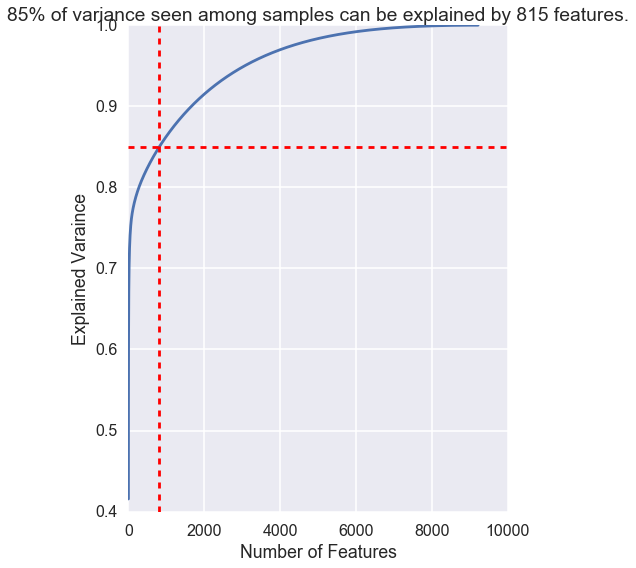

In [98]:
# Plot variance explained
cumulative = np.cumsum(pca.explained_variance_ratio_)
loc = np.argwhere(cumulative >= 0.85)[0, 0]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(cumulative)
ax.axvline(loc, color='r', ls='--')
ax.axhline(.85, color='r', ls='--')
ax.set_title("85% of variance seen among samples can be explained by {} features.".format(loc))
ax.set_ylabel('Explained Varaince')
ax.set_xlabel('Number of Features')
plt.tight_layout()

In [100]:
jean_projected = projection[:, :loc]

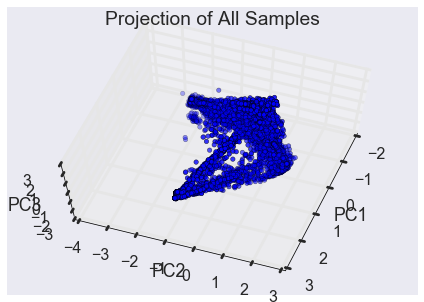

In [101]:
fig = plt.figure(1)
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=68, azim=20)
ax.scatter(jean_projected[:,0], jean_projected[:, 1], jean_projected[:, 2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
_ = ax.set_title('Projection of All Samples')

http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [39]:
def sillhouette(X, Method=AgglomerativeClustering, clusters=[1000, 14000]):
    range_n_clusters = clusters
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = Method(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, -0.5, -0.25, 0, 0.25, 0.5, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

# Kmeans

For n_clusters = 100 The average silhouette_score is : -0.122032419365


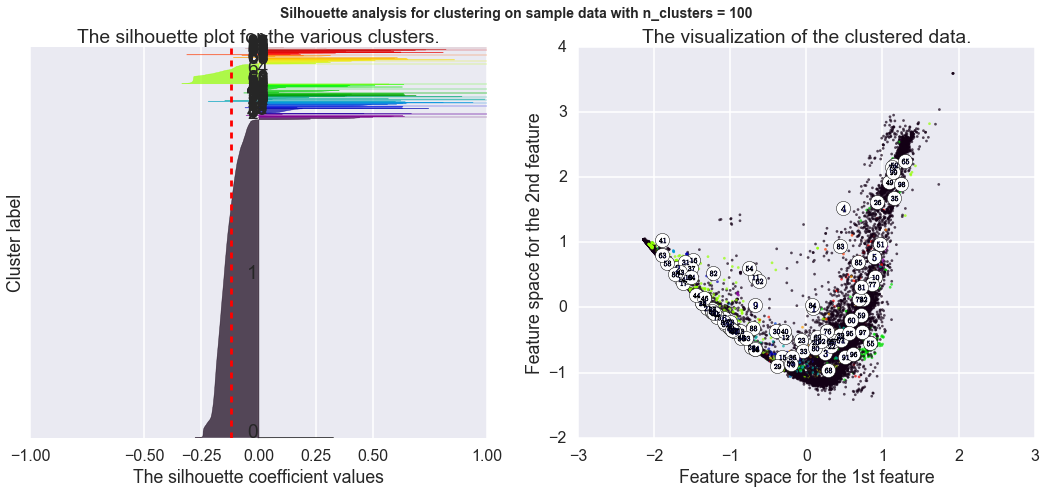

In [34]:
sillhouette(jean_projected, KMeans, [100])

http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index

# Agglomerative Clustering

In [ ]:
sillhouette(jean_projected, AgglomerativeClustering)

For n_clusters = 1000 The average silhouette_score is : 0.0328404251822


# DBSCAN

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)